In [1]:
import pandas as pd

df = pd.read_csv("D:/Ramadhanul Husna/ds-takehome/data/credit_scoring.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [3]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


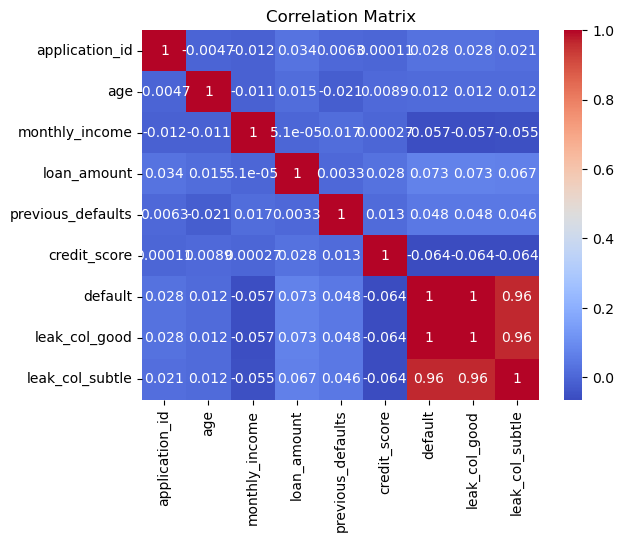

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cek korelasi antar fitur
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Drop fitur leakage
df.drop(columns=["leak_col_good", "leak_col_subtle"], inplace=True)



In [5]:
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


In [6]:
# Pisahkan fitur dan target
X = df.drop(columns=["application_id", "default"])
y = df["default"]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
probs_lr = lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, probs_lr)
print(f"AUC Logistic Regression: {auc_lr:.4f}")



AUC Logistic Regression: 0.7178


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Definisikan parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

# Model dasar
gb = GradientBoostingClassifier(random_state=42)

# GridSearch dengan AUC sebagai scoring
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit ke data train
grid_search.fit(X_train, y_train)

# Hasil terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score (CV):", grid_search.best_score_)

best_gb = grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best AUC Score (CV): 0.7773760193385387


In [9]:
# Prediksi probabilitas default dari model hasil tuning
probs_best_gb = best_gb.predict_proba(X_test)[:, 1]

# Fungsi untuk konversi ke skor industri (300–850)
def prob_to_score(prob, min_score=300, max_score=850):
    return min_score + (1 - prob) * (max_score - min_score)

# Konversi ke skor
scores = prob_to_score(probs_best_gb)

# Gabungkan dengan ID aplikasi
score_df = pd.DataFrame({
    "application_id": df.loc[X_test.index, "application_id"].values,
    "Prob Default": probs_best_gb,
    "Score": scores
})

print(score_df.head())


   application_id  Prob Default       Score
0          501822      0.000195  849.892642
1          504853      0.000291  849.839801
2          506086      0.000288  849.841754
3          502931      0.003529  848.058960
4          503209      0.000933  849.487082


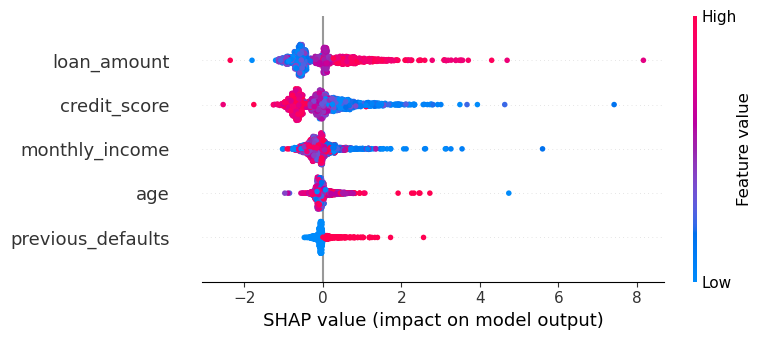

In [11]:
import shap

# SHAP explainer
explainer = shap.Explainer(best_gb)
shap_values = explainer(X_test)

# Plot top-10 fitur
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.savefig("shap_top10_features.png")


In [13]:
# Ambil 1 nasabah contoh
sample = X_test.iloc[[0]]
sample_id = df.loc[sample.index[0], 'application_id']
sample_prob = best_gb.predict_proba(sample)[0, 1]
sample_score = prob_to_score(sample_prob)

# Tampilkan hasil
print("Application ID:", sample_id)
print(f"Probabilitas gagal bayar: {sample_prob:.2f}")
print(f"Skor risiko: {sample_score:.0f}")


shap_values_sample = explainer(sample)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_value': shap_values_sample.values[0]
})
top3 = shap_df.reindex(shap_df.shap_value.abs().sort_values(ascending=False).index).head(3)

print("\nTop 3 fitur penyumbang risiko:")
print(top3)


Application ID: 501822
Probabilitas gagal bayar: 0.00
Skor risiko: 850

Top 3 fitur penyumbang risiko:
             feature  shap_value
4       credit_score   -0.955702
3  previous_defaults    0.474652
2        loan_amount   -0.416817


In [14]:
# Pinjaman yang diminta
jumlah_pinjaman = 5_000_000  # 5 juta rupiah

# Ambil 1 contoh nasabah
sample = X_test.iloc[[0]]
prob_default = best_gb.predict_proba(sample)[0, 1]
skor = prob_to_score(prob_default)

# Hitung potensi kerugian
resiko_kerugian = prob_default * jumlah_pinjaman

print(f"Probabilitas gagal bayar: {prob_default:.2f}")
print(f"Skor risiko (300–850): {skor:.0f}")
print(f"Estimasi kerugian jika gagal bayar: IDR {resiko_kerugian:,.0f}")


Probabilitas gagal bayar: 0.00
Skor risiko (300–850): 850
Estimasi kerugian jika gagal bayar: IDR 976


In [16]:
# Salin test set
test_set = X_test.copy()

# Prediksi probabilitas default
test_set["PD"] = best_gb.predict_proba(X_test)[:, 1]

# Hitung skor risiko
test_set["Scorecard"] = prob_to_score(test_set["PD"])  # Ganti nama di sini

# Asumsi
EAD = 5_000_000  # 5 juta
LGD = 1.0  # 100%
batas_kerugian = 500_000  # maksimal risiko kerugian

# Hitung estimasi kerugian
test_set["Expected_Loss"] = test_set["PD"] * LGD * EAD

# Keputusan
test_set["Keputusan"] = test_set.apply(
    lambda row: "Disetujui" if row["Scorecard"] >= 650 and row["Expected_Loss"] <= batas_kerugian else "Ditolak",
    axis=1
)

# Tambahkan application_id dan default dari data asli
test_set["application_id"] = df.loc[test_set.index, "application_id"]
test_set["default_actual"] = df.loc[test_set.index, "default"]

# Tampilkan sebagian hasil
test_set[["application_id", "Scorecard", "PD", "Expected_Loss", "Keputusan"]].head()


,application_id,Scorecard,PD,Expected_Loss,Keputusan
822,501822,849.892642,0.000195,975.985202,Disetujui
3853,504853,849.839801,0.000291,1456.357469,Disetujui
5086,506086,849.841754,0.000288,1438.602077,Disetujui
1931,502931,848.058960,0.003529,17645.822630,Disetujui
2209,503209,849.487082,0.000933,4662.893719,Disetujui


In [19]:
ditolak = test_set[test_set["Keputusan"] == "Ditolak"]
ditolak_tampil = ditolak[["application_id", "Scorecard", "PD", "Expected_Loss", "Keputusan"]]
print(ditolak_tampil.head(10))  # tampilkan 10 teratas


      application_id   Scorecard        PD  Expected_Loss Keputusan
2070          503070  753.393716  0.175648   8.782389e+05   Ditolak
3779          504779  470.399441  0.690183   3.450914e+06   Ditolak
1317          502317  767.233969  0.150484   7.524185e+05   Ditolak
3220          504220  533.178615  0.576039   2.880194e+06   Ditolak
783           501783  767.710222  0.149618   7.480889e+05   Ditolak
5171          506171  301.990503  0.996381   4.981905e+06   Ditolak
3035          504035  577.426415  0.495588   2.477942e+06   Ditolak
5454          506454  484.294666  0.664919   3.324594e+06   Ditolak
2176          503176  480.332802  0.672122   3.360611e+06   Ditolak
1191          502191  627.329387  0.404856   2.024278e+06   Ditolak
